### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import datetime, time
import platform
import itertools
# Used for mathematical functions
import math             
import logging



# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
# import pyproj
# import shapely.geometry
# from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import tqdm


# Used for making the graph to visualize our problem
# import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# OpenTNSim
import opentnsim

# turn on debug messages if want to see what's going on in detail
# logging.basicConfig(level=logging.DEBUG)
# turn off debug messages, only show info and higher level messages
logging.basicConfig(level=logging.INFO)

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [2]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [3]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later

data_vessel = {
    "env": None,
    "name": 'Vessel M9',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "type": None,
    "B": 11.45,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.75,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat":True, # if consider the ship squatting while moving, set to True, otherwise set to False
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2200.0,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "L_w": 3.0 ,
    "C_B":0.85, 
    "C_year": 1990,
}             



In [4]:
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

### Set vessel properties and sailing conditions ( input value )

In [5]:
V_s = np.linspace(0.1, 8, 200)          # ship sailing speeds to water, (m/s)
h_0 = [10, 7.5, 5, 3.5]                 # water depths,(m)
C_year = [1970, 1980, 1990, 2000, 2010, 2020]   # engine construction years



### prepare input matrix for calculation

In [6]:
# prepare the work to be done
# create a list of all combinations
work = list(itertools.product(C_year, h_0, V_s))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"C_year": item[0], "h_0": item[1], "V_s": item[2]}
    rows.append(row)

# these are all the simulations that we want to run
# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.tail()

,C_year,h_0,V_s
4795,2020,3.5,7.841206
4796,2020,3.5,7.880905
4797,2020,3.5,7.920603
4798,2020,3.5,7.960302
4799,2020,3.5,8.000000


In [7]:

results = []

for i, row in tqdm.tqdm(work_df.iterrows()):
    # create a new vessel, like the one above (so that it also has L)
    C_year = row['C_year']
    data_vessel_i = data_vessel.copy()
    data_vessel_i['C_year'] = C_year
    vessel = TransportResource(**data_vessel_i)
    
    V_s = row['V_s']
    h_0 = row['h_0']
    vessel.calculate_properties() # L is used here in the computation of L_R
    h_0 = vessel.calculate_h_squat(v = V_s, h_0 = h_0)
    print(h_0)
    R_f = vessel.calculate_frictional_resistance(V_s, h_0) 
    R_f_one_k1 = vessel.calculate_viscous_resistance()
    R_APP = vessel.calculate_appendage_resistance(V_s)
    R_W = vessel.calculate_wave_resistance(V_s, h_0)
    R_res = vessel.calculate_residual_resistance(V_s, h_0)
    R_T = vessel.calculate_total_resistance(V_s, h_0)
    P_tot = vessel.calculate_total_power_required(V_s)
    vessel.emission_factors_general()
    vessel.correction_factors(V_s)
    vessel.calculate_emission_factors_total(V_s)
    Fuel_g_m = vessel.calculate_fuel_use_g_m(V_s)
    [emission_g_m_CO2,emission_g_m_PM10,emission_g_m_NOX] = vessel.calculate_emission_rates_g_m(V_s)
    
    result = {}
    result.update(row)
    result['P_installed'] = vessel.P_installed
    result['R_f_one_k1'] = R_f_one_k1
    result['R_APP'] = R_APP
    result['R_W'] = R_W
    result['R_res'] = R_res
    result['R_T'] = R_T
    result['P_tot'] = P_tot
    result['Fuel_g_km'] = Fuel_g_m * 1000
    result['emission_g_km_CO2'] = emission_g_m_CO2 * 1000
    result['emission_g_km_PM10'] = emission_g_m_PM10 * 1000
    result['emission_g_km_NOX'] = emission_g_m_NOX * 1000
    results.append(result)

12it [00:00, 116.82it/s]

9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221


24it [00:00, 88.13it/s] 

9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925


42it [00:00, 74.60it/s]

9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604


59it [00:00, 70.94it/s]

9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221


67it [00:00, 71.39it/s]

9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405


82it [00:01, 67.31it/s]

9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657


97it [00:01, 65.29it/s]

9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767


111it [00:01, 61.32it/s]

9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801


126it [00:01, 63.53it/s]

9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175


133it [00:01, 64.71it/s]

9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164


148it [00:02, 65.76it/s]

9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379


162it [00:02, 55.03it/s]

9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924


168it [00:02, 51.06it/s]

9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106


180it [00:02, 47.46it/s]

9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737


186it [00:02, 49.72it/s]

9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359


197it [00:03, 43.63it/s]

9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805


204it [00:03, 48.91it/s]

9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805


219it [00:03, 58.35it/s]

7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482


234it [00:03, 62.75it/s]

7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976


249it [00:04, 66.81it/s]

7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555


265it [00:04, 70.35it/s]

7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133


281it [00:04, 69.24it/s]

7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507


296it [00:04, 69.18it/s]

7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684


312it [00:04, 72.35it/s]

7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231


320it [00:05, 69.06it/s]

7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674


337it [00:05, 71.87it/s]

7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435


345it [00:05, 64.91it/s]

7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259


352it [00:05, 53.12it/s]

7.401990370605934
7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876


364it [00:05, 44.56it/s]

7.390919524427054
7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103


369it [00:06, 42.36it/s]

7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846


379it [00:06, 39.32it/s]

7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551


383it [00:06, 38.87it/s]

7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973


392it [00:06, 38.03it/s]

7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574


400it [00:06, 37.19it/s]

7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706


414it [00:07, 48.94it/s]

4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159


426it [00:07, 51.81it/s]

4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848


438it [00:07, 53.08it/s]

4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965


450it [00:07, 54.28it/s]

4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937


456it [00:07, 54.95it/s]

4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435


468it [00:08, 54.67it/s]

4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285


480it [00:08, 54.07it/s]

4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401


492it [00:08, 54.23it/s]

4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425


504it [00:08, 54.05it/s]

4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555


516it [00:09, 53.62it/s]

4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145


528it [00:09, 51.06it/s]

4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941


534it [00:09, 49.45it/s]

4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105


544it [00:09, 42.88it/s]

4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086


554it [00:09, 40.72it/s]

4.869431714627821
4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623


559it [00:10, 38.16it/s]

4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707


567it [00:10, 37.87it/s]

4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338


575it [00:10, 37.05it/s]

4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922


584it [00:10, 37.36it/s]

4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045


592it [00:10, 37.12it/s]

4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601


600it [00:11, 36.35it/s]

4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164


612it [00:11, 46.81it/s]

3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354


624it [00:11, 51.18it/s]

3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949


648it [00:11, 84.00it/s]

3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357


665it [00:12, 68.72it/s]

3.476634984951299
3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334


673it [00:12, 64.08it/s]

3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165


680it [00:12, 61.81it/s]

3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857


694it [00:12, 57.65it/s]

3.439188557449
3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216


706it [00:12, 54.28it/s]

3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655


712it [00:13, 51.24it/s]

3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397


723it [00:13, 43.50it/s]

3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878


728it [00:13, 41.25it/s]

3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003


738it [00:13, 39.23it/s]

3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684


746it [00:13, 37.83it/s]

3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432


754it [00:14, 37.39it/s]

3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846


762it [00:14, 36.88it/s]

3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732


770it [00:14, 37.11it/s]

3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574


778it [00:14, 35.30it/s]

3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405


787it [00:15, 37.32it/s]

3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214


797it [00:15, 41.63it/s]

3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505


805it [00:15, 50.68it/s]

3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682


820it [00:15, 62.05it/s]

9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196


837it [00:15, 63.58it/s]

9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166


857it [00:16, 79.06it/s]

9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267
9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987


880it [00:16, 92.58it/s]

9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126


891it [00:16, 94.61it/s]

9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775


901it [00:16, 95.61it/s]

9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452


911it [00:16, 95.14it/s]

9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652


921it [00:16, 82.83it/s]

9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492


930it [00:16, 77.21it/s]

9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037


938it [00:17, 68.26it/s]

9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487


946it [00:17, 60.55it/s]

9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379


953it [00:17, 53.66it/s]

9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605


959it [00:17, 48.09it/s]

9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274


965it [00:17, 41.51it/s]

9.904335658032764
9.903144011895332
9.901944704222874


970it [00:17, 39.85it/s]

9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246


975it [00:18, 39.30it/s]

9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503


980it [00:18, 39.04it/s]

9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356


984it [00:18, 38.53it/s]

9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602


988it [00:18, 37.34it/s]

9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174


992it [00:18, 36.58it/s]

9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982


996it [00:18, 36.45it/s]

9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504


1006it [00:18, 51.10it/s]

7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342


1012it [00:18, 51.32it/s]

7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471


1018it [00:18, 51.59it/s]

7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734


1024it [00:19, 52.27it/s]

7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141


1030it [00:19, 52.83it/s]

7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557


1036it [00:19, 53.80it/s]

7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785


1042it [00:19, 54.51it/s]

7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371


1048it [00:19, 54.66it/s]

7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975


1054it [00:19, 54.68it/s]

7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764


1060it [00:19, 54.50it/s]

7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316


1066it [00:19, 54.77it/s]

7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233


1072it [00:19, 54.75it/s]

7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527


1078it [00:20, 54.30it/s]

7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507


1084it [00:20, 54.71it/s]

7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743


1090it [00:20, 54.03it/s]

7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622


1096it [00:20, 54.23it/s]

7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896


1102it [00:20, 54.36it/s]

7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985


1108it [00:20, 54.31it/s]

7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667


1114it [00:20, 53.27it/s]

7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999


1120it [00:20, 53.12it/s]

7.440163521563365
7.439117475854401
7.438062014098623


1126it [00:20, 52.86it/s]

7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447


1138it [00:21, 51.63it/s]

7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055


1144it [00:21, 50.80it/s]

7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325


1150it [00:21, 46.87it/s]

7.403331018547259
7.401990370605934


1155it [00:21, 43.44it/s]

7.400640132598452
7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054


1160it [00:21, 41.00it/s]

7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784


1165it [00:21, 38.84it/s]

7.382212085910103
7.380727070237857


1169it [00:22, 38.15it/s]

7.3792323918019065
7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253


1177it [00:22, 37.13it/s]

7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226


1185it [00:22, 36.10it/s]

7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872


1193it [00:22, 35.70it/s]

7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619


1202it [00:22, 37.70it/s]

7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833


1214it [00:23, 46.10it/s]

4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899


1220it [00:23, 48.63it/s]

4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385


1226it [00:23, 50.70it/s]

4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295


1232it [00:23, 52.03it/s]

4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605


1238it [00:23, 53.03it/s]

4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256


1244it [00:23, 53.94it/s]

4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937


1250it [00:23, 54.80it/s]

4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321


1256it [00:23, 54.92it/s]

4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435


1262it [00:24, 55.93it/s]

4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742


1268it [00:24, 54.62it/s]

4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071


1274it [00:24, 54.49it/s]

4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497


1280it [00:24, 54.40it/s]

4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375


1286it [00:24, 54.30it/s]

4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773


1292it [00:24, 53.98it/s]

4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135


1298it [00:24, 53.87it/s]

4.945570206815425
4.944402833639336
4.943222592802718


1304it [00:24, 53.78it/s]

4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117


1310it [00:24, 53.10it/s]

4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758


1316it [00:25, 52.27it/s]

4.918339867056803
4.916900206255145
4.915447477335699


1322it [00:25, 52.12it/s]

4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488


1328it [00:25, 51.84it/s]

4.90178343538941
4.9001995566369265
4.898602517395835


1334it [00:25, 50.75it/s]

4.8969923096277945
4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428


1340it [00:25, 44.70it/s]

4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604


1345it [00:25, 42.64it/s]

4.871253668650086
4.869431714627821


1350it [00:25, 40.68it/s]

4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953


1359it [00:26, 38.44it/s]

4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932


1367it [00:26, 37.19it/s]

4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338


1375it [00:26, 35.62it/s]

4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526


1384it [00:26, 38.40it/s]

4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045


1388it [00:26, 37.55it/s]

4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694


1392it [00:26, 36.38it/s]

4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601


1396it [00:27, 36.40it/s]

4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083


1400it [00:27, 36.86it/s]

3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164


1406it [00:27, 41.84it/s]

3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334


1412it [00:27, 45.28it/s]

3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145


1418it [00:27, 47.96it/s]

3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265


1424it [00:27, 50.10it/s]

3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108


1430it [00:27, 50.95it/s]

3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949


1436it [00:27, 52.25it/s]

3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065


1442it [00:27, 52.58it/s]

3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606


1448it [00:28, 52.91it/s]

3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083


1454it [00:28, 52.71it/s]

3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673


1460it [00:28, 53.36it/s]

3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438


1466it [00:28, 53.46it/s]

3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715


1478it [00:28, 53.42it/s]

3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907


1484it [00:28, 53.09it/s]

3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136
3.4363285001956743


1490it [00:28, 52.73it/s]

3.434872863696806
3.4334001354287103
3.4319103006850655


1496it [00:28, 52.47it/s]

3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171


1502it [00:29, 52.68it/s]

3.4177296390907004
3.4160679610444498
3.414389023656239


1508it [00:29, 52.15it/s]

3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963


1519it [00:29, 44.43it/s]

3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998


1524it [00:29, 41.78it/s]

3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005


1529it [00:29, 39.99it/s]

3.368884110065212
3.3667696839192347


1534it [00:29, 38.96it/s]

3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067


1539it [00:30, 40.49it/s]

3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621


1547it [00:30, 48.79it/s]

3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876


1554it [00:30, 53.20it/s]

3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846
3.29776723014854
3.295121348545698


1561it [00:30, 57.01it/s]

3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656


1569it [00:30, 61.72it/s]

3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696


1576it [00:30, 51.13it/s]

3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405


1582it [00:30, 49.04it/s]

3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113


1588it [00:30, 44.48it/s]

3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913


1593it [00:31, 41.53it/s]

3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293
3.1779161315430833


1598it [00:31, 39.80it/s]

3.1745492947260505
3.171164275089169
9.999984538666912


1603it [00:31, 40.96it/s]

9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458


1609it [00:31, 44.41it/s]

9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817


1615it [00:31, 47.29it/s]

9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897


1621it [00:31, 49.37it/s]

9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341


1627it [00:31, 50.97it/s]

9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052


1633it [00:31, 52.05it/s]

9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562


1639it [00:32, 52.96it/s]

9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051


1645it [00:32, 52.76it/s]

9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648


1651it [00:32, 53.44it/s]

9.991430511862456
9.991087628256267


1657it [00:32, 54.06it/s]

9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163


1670it [00:32, 55.85it/s]

9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405


1676it [00:32, 55.06it/s]

9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259


1682it [00:32, 54.66it/s]

9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655


1688it [00:32, 54.59it/s]

9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888


1694it [00:33, 55.95it/s]

9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126


1700it [00:33, 54.61it/s]

9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087


1706it [00:33, 54.63it/s]

9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474


1712it [00:33, 53.53it/s]

9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705


1718it [00:33, 53.10it/s]

9.95260138524986
9.951772775029712
9.950936706022098


1724it [00:33, 52.91it/s]

9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497


1730it [00:33, 52.43it/s]

9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313


1736it [00:33, 51.44it/s]

9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164


1742it [00:33, 50.64it/s]

9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423


1749it [00:34, 55.24it/s]

9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379


1758it [00:34, 64.13it/s]

9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274


1765it [00:34, 64.55it/s]

9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815


1772it [00:34, 64.63it/s]

9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536


1779it [00:34, 51.61it/s]

9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383


1785it [00:34, 42.05it/s]

9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892


1790it [00:34, 36.38it/s]

9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169


1799it [00:35, 31.56it/s]

9.865239288241982
9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206


1804it [00:35, 33.99it/s]

7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011
7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224


1814it [00:35, 47.72it/s]

7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856


1824it [00:35, 59.09it/s]

7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459


1831it [00:35, 58.64it/s]

7.496502134453544
7.496259518112496
7.496008443775881
7.495748890279934


1838it [00:35, 59.31it/s]

7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371


1845it [00:36, 57.91it/s]

7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522


1852it [00:36, 56.44it/s]

7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555


1858it [00:36, 55.80it/s]

7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954


1864it [00:36, 55.56it/s]

7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316


1870it [00:36, 55.17it/s]

7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052


1877it [00:36, 58.10it/s]

7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855


1884it [00:36, 59.93it/s]

7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249


1897it [00:36, 57.08it/s]

7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996


1903it [00:37, 56.24it/s]

7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154


1909it [00:37, 54.77it/s]

7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788


1915it [00:37, 54.45it/s]

7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401


1921it [00:37, 54.44it/s]

7.438062014098623
7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971


1930it [00:37, 62.80it/s]

7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801


1937it [00:37, 58.27it/s]

7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662


1943it [00:37, 55.62it/s]

7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168


1949it [00:37, 50.15it/s]

7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452
7.3992802994766596


1955it [00:38, 47.33it/s]

7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214
7.388055614455868


1960it [00:38, 42.73it/s]

7.386609203026049
7.385153147609987
7.383687443473784


1965it [00:38, 40.90it/s]

7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762
7.376214028146288


1970it [00:38, 39.28it/s]

7.374690333743417
7.373156958209866


1974it [00:38, 38.07it/s]

7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225
7.363753149278088
7.362151880334452


1982it [00:38, 37.09it/s]

7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195


1990it [00:39, 36.78it/s]

7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015


1998it [00:39, 35.82it/s]

7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105


2009it [00:39, 43.24it/s]

4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513


2021it [00:39, 49.87it/s]

4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047


2033it [00:39, 52.63it/s]

4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091


2039it [00:40, 52.99it/s]

4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455


2051it [00:40, 52.80it/s]

4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124


2063it [00:40, 54.28it/s]

4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905


2075it [00:40, 54.42it/s]

4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122


2087it [00:40, 54.83it/s]

4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664


2099it [00:41, 54.47it/s]

4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295


2111it [00:41, 53.14it/s]

4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708


2117it [00:41, 53.57it/s]

4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468


2129it [00:41, 52.09it/s]

4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502


2141it [00:41, 51.74it/s]

4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455


2149it [00:42, 56.72it/s]

4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422


2156it [00:42, 58.06it/s]

4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536


2163it [00:42, 59.56it/s]

4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871


2169it [00:42, 53.05it/s]

4.825972254848084
4.823842731288197
4.821699756462338


2175it [00:42, 51.71it/s]

4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526


2181it [00:42, 45.97it/s]

4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471


2186it [00:42, 42.78it/s]

4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806


2191it [00:43, 40.63it/s]

4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601


2196it [00:43, 38.91it/s]

4.761241165459889
4.758732743284884
4.756210706131813


2200it [00:43, 37.77it/s]

4.753675048554083
3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164


2206it [00:43, 42.50it/s]

3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334


2212it [00:43, 45.95it/s]

3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354


2218it [00:43, 48.43it/s]

3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265


2224it [00:43, 49.61it/s]

3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477


2230it [00:43, 50.93it/s]

3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949


2236it [00:43, 51.47it/s]

3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396


2243it [00:44, 53.78it/s]

3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002


2249it [00:44, 54.12it/s]

3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299


2256it [00:44, 57.10it/s]

3.475766891165673
3.4748823433246456
3.473981318723149
3.473063795010337


2262it [00:44, 56.22it/s]

3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383


2269it [00:44, 58.76it/s]

3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722


2276it [00:44, 60.26it/s]

3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061
3.4512168045692233


2283it [00:44, 58.12it/s]

3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283


2289it [00:44, 56.38it/s]

3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449
3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245


2295it [00:44, 54.65it/s]

3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498


2304it [00:45, 64.05it/s]

3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666


2313it [00:45, 69.56it/s]

3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363


2321it [00:45, 65.19it/s]

3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568
3.3709809781977005
3.368884110065212


2328it [00:45, 57.43it/s]

3.3667696839192347
3.36463768895294
3.3624881144354077


2334it [00:45, 49.05it/s]

3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766


2340it [00:45, 45.00it/s]

3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792


2347it [00:45, 49.17it/s]

3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433
3.3157890209852328


2353it [00:46, 48.05it/s]

3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062


2358it [00:46, 44.24it/s]

3.300395258646846
3.29776723014854


2363it [00:46, 41.20it/s]

3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732
3.2760995468166656


2368it [00:46, 39.58it/s]

3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954


2373it [00:46, 37.11it/s]

3.259096260927369
3.2561995208627574


2378it [00:46, 38.66it/s]

3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773


2382it [00:46, 37.83it/s]

3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397


2387it [00:46, 40.00it/s]

3.213753374389424
3.2105860611446615
3.2074006469650214
3.204197124228164
3.2009754853484695
3.197735722776671


2392it [00:47, 41.26it/s]

3.1944778289994913
3.1912017965392883
3.187907617953702


2397it [00:47, 37.82it/s]

3.184595285835312
3.181264792811293
3.1779161315430833
3.1745492947260505


2401it [00:47, 36.73it/s]

3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314


2407it [00:47, 41.04it/s]

9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088
9.99975443546458
9.999697724695755


2413it [00:47, 45.83it/s]

9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403


2423it [00:47, 58.66it/s]

9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054
9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196


2430it [00:47, 57.57it/s]

9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562


2436it [00:47, 56.61it/s]

9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051


2442it [00:48, 56.05it/s]

9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825


2448it [00:48, 54.51it/s]

9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267


2454it [00:48, 54.32it/s]

9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226


2460it [00:48, 54.14it/s]

9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163


2466it [00:48, 53.92it/s]

9.986424975745141
9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688


2472it [00:48, 53.86it/s]

9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253


2478it [00:48, 54.39it/s]

9.981252781018405
9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259


2484it [00:48, 54.19it/s]

9.977508928572439
9.97694517659006
9.976374174575279


2490it [00:48, 54.63it/s]

9.97579591570262
9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321


2502it [00:49, 53.76it/s]

9.968954233436408
9.968288384955327
9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452


2514it [00:49, 54.22it/s]

9.961225267458106
9.960478367097698
9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705


2520it [00:49, 53.48it/s]

9.95260138524986
9.951772775029712
9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175


2526it [00:49, 53.12it/s]

9.944874967216492


2532it [00:49, 52.81it/s]

9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117


2544it [00:49, 50.93it/s]

9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703


2555it [00:50, 49.42it/s]

9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836


2560it [00:50, 46.17it/s]

9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574


2565it [00:50, 42.91it/s]

9.906695980311042
9.905519646282274
9.904335658032764
9.903144011895332


2570it [00:50, 40.99it/s]

9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798


2575it [00:50, 39.24it/s]

9.89207399638121
9.890805573978126
9.88952945462536


2579it [00:50, 38.36it/s]

9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018
9.883033283813692


2583it [00:50, 37.47it/s]

9.881710911123356
9.880380817763383
9.879043000412656


2587it [00:51, 37.19it/s]

9.877697455766402
9.87634418053602
9.87498317144892
9.873614425248359
9.872237938693283
9.870853708558174


2592it [00:51, 39.21it/s]

9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982


2599it [00:51, 45.67it/s]

9.863816292356805
9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011


2608it [00:51, 57.36it/s]

7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484


2619it [00:51, 71.88it/s]

7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544


2629it [00:51, 78.57it/s]

7.496259518112496
7.496008443775881


2638it [00:51, 68.75it/s]

7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691


2646it [00:51, 64.67it/s]

7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809


2660it [00:52, 58.72it/s]

7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841


2673it [00:52, 56.37it/s]

7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899


2685it [00:52, 54.59it/s]

7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713


2691it [00:52, 54.91it/s]

7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684


2704it [00:52, 56.58it/s]

7.459117105490306
7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154


2716it [00:53, 54.81it/s]

7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365


2731it [00:53, 57.67it/s]

7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447


2737it [00:53, 56.10it/s]

7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055


2749it [00:53, 50.31it/s]

7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452


2755it [00:53, 45.19it/s]

7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214


2765it [00:54, 39.77it/s]

7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762


2774it [00:54, 38.01it/s]

7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194


2778it [00:54, 37.60it/s]

7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687


2786it [00:54, 37.05it/s]

7.352340064624668
7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479


2794it [00:55, 36.82it/s]

7.338711914542257
7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363


2803it [00:55, 39.30it/s]

7.324458134391829
7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598


2815it [00:55, 48.18it/s]

4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899


2827it [00:55, 49.94it/s]

4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874


2839it [00:55, 52.78it/s]

4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605


2851it [00:56, 52.19it/s]

4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901


2864it [00:56, 55.38it/s]

4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046


2876it [00:56, 55.01it/s]

4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471


2882it [00:56, 54.47it/s]

4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225


2904it [00:56, 79.89it/s]

4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708
4.925342459055058
4.923968005740461


2928it [00:57, 97.50it/s]

4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502
4.89373235663688


2938it [00:57, 73.25it/s]

4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428
4.881906556789316
4.880164233583892


2947it [00:57, 56.99it/s]

4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828


2954it [00:57, 50.42it/s]

4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953
4.852434905920422
4.850479663559904


2960it [00:57, 46.47it/s]

4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155


2971it [00:58, 39.40it/s]

4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338


2976it [00:58, 35.49it/s]

4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988


2980it [00:58, 32.26it/s]

4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025


2988it [00:58, 32.57it/s]

4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675


2995it [00:59, 39.64it/s]

4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083


3000it [00:59, 41.48it/s]

3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929


3008it [00:59, 50.33it/s]

3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481


3015it [00:59, 55.16it/s]

3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005
3.4962281666370076
3.4958869211745265


3023it [00:59, 61.34it/s]

3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579


3031it [00:59, 66.29it/s]

3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195


3038it [00:59, 59.94it/s]

3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767


3045it [00:59, 54.08it/s]

3.4851049363862763
3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923


3051it [01:00, 49.71it/s]

3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456


3057it [01:00, 46.71it/s]

3.473981318723149
3.473063795010337


3062it [01:00, 45.07it/s]

3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383


3067it [01:00, 43.57it/s]

3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715


3072it [01:00, 43.07it/s]

3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165


3077it [01:00, 42.50it/s]

3.453703396953223
3.452468543748061
3.4512168045692233
3.449948162525676


3083it [01:00, 44.81it/s]

3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305


3088it [01:00, 42.87it/s]

3.4405930083634857
3.439188557449


3093it [01:01, 42.56it/s]

3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654


3098it [01:01, 41.22it/s]

3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498


3103it [01:01, 42.61it/s]

3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327


3108it [01:01, 44.11it/s]

3.40750041932655
3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997


3113it [01:01, 42.41it/s]

3.3966475472787963
3.39477791318667


3118it [01:01, 44.12it/s]

3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568


3127it [01:01, 54.73it/s]

3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294


3133it [01:01, 48.19it/s]

3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885


3138it [01:02, 44.05it/s]

3.34465739093766
3.34234912956462
3.340023185274684
3.3376795481040546
3.3353182081530477


3143it [01:02, 41.73it/s]

3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068


3148it [01:02, 37.88it/s]

3.3207778635432
3.3182923321486433


3152it [01:02, 37.44it/s]

3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062


3156it [01:02, 36.45it/s]

3.300395258646846
3.29776723014854
3.295121348545698
3.2924576049105125


3160it [01:02, 36.04it/s]

3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967


3164it [01:02, 35.80it/s]

3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196


3168it [01:02, 35.72it/s]

3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369


3172it [01:02, 36.40it/s]

3.2561995208627574
3.2532847988728464
3.2503520867362763
3.2474013762746696


3176it [01:03, 36.03it/s]

3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476


3180it [01:03, 35.78it/s]

3.232377565798405
3.229318695989773
3.2262417717727017


3184it [01:03, 35.42it/s]

3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615


3188it [01:03, 35.46it/s]

3.2074006469650214
3.204197124228164


3192it [01:03, 35.09it/s]

3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312


3196it [01:03, 35.76it/s]

3.181264792811293
3.1779161315430833


3200it [01:03, 35.77it/s]

3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966


3206it [01:03, 41.81it/s]

9.999805058694088
9.99975443546458


3212it [01:03, 46.57it/s]

9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054


3218it [01:04, 50.11it/s]

9.998786663650897
9.998660427282221


3224it [01:04, 51.28it/s]

9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196
9.99703703051052


3236it [01:04, 52.97it/s]

9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166
9.994477326793051


3248it [01:04, 53.38it/s]

9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267


3261it [01:04, 55.66it/s]

9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141


3273it [01:05, 53.83it/s]

9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405


3285it [01:05, 55.20it/s]

9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262
9.975210393219655
9.974617600445379


3297it [01:05, 54.98it/s]

9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327
9.967615196994126


3309it [01:05, 55.02it/s]

9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698
9.959724064842474


3315it [01:05, 54.47it/s]

9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712
9.950936706022098


3327it [01:06, 53.63it/s]

9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912
9.942164715482384
9.94124628218399


3339it [01:06, 52.48it/s]

9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502
9.93264164245164
9.93164785290461
9.930646503847248


3345it [01:06, 47.40it/s]

9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703
9.922363067031545


3355it [01:06, 40.30it/s]

9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605


3360it [01:06, 37.00it/s]

9.912462966930836
9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042


3368it [01:07, 30.98it/s]

9.905519646282274
9.904335658032764
9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546


3372it [01:07, 28.47it/s]

9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037
9.893334725292798
9.89207399638121


3379it [01:07, 28.86it/s]

9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645
9.884347939172018


3385it [01:07, 28.01it/s]

9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892


3393it [01:08, 31.84it/s]

9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805


3401it [01:08, 34.74it/s]

9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011


3413it [01:08, 44.54it/s]

7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266


3425it [01:08, 49.58it/s]

7.498468272233856
7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544


3437it [01:08, 52.75it/s]

7.496259518112496
7.496008443775881
7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976


3449it [01:09, 54.60it/s]

7.493028122910298
7.492682729186691
7.492328656311962
7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496


3461it [01:09, 53.52it/s]

7.488307250452809
7.487856729788764
7.487397359215555
7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841


3475it [01:09, 57.86it/s]

7.482314221867501
7.481756709331316
7.481190207247379
7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899


3481it [01:09, 57.23it/s]

7.475685458036307
7.475028500665527
7.474362444541286
7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117


3493it [01:09, 55.51it/s]

7.467199474750743
7.466432746183333
7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306


3505it [01:10, 53.96it/s]

7.458257993451896
7.457389601072382
7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512


3517it [01:10, 53.09it/s]

7.448193672860667
7.447222725473739
7.446242413638231
7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623


3529it [01:10, 52.83it/s]

7.436997130069365
7.435922817586924
7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447


3535it [01:10, 52.51it/s]

7.424659800464858
7.42348137986801
7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939


3547it [01:11, 50.73it/s]

7.4124474628863055
7.41117380142662
7.409890586121304
7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452


3558it [01:11, 42.39it/s]

7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054


3563it [01:11, 40.78it/s]

7.389492386660214
7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065


3572it [01:11, 38.40it/s]

7.377728045972762
7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194


3583it [01:11, 44.61it/s]

7.365344705882225
7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668
7.350670688306655
7.348991565339195


3593it [01:12, 42.08it/s]

7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257
7.336964448776275
7.335207203386015


3598it [01:12, 39.81it/s]

7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829
7.322632319752164
4.9999728930139105


3609it [01:12, 44.91it/s]

4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785
4.999238841466854
4.999106910384513


3620it [01:12, 47.39it/s]

4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489
4.997174587188624
4.996918966325047


3632it [01:12, 51.09it/s]

4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978
4.993339770711091


3645it [01:13, 54.96it/s]

4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256
4.988842374646401
4.9883264725657455


3653it [01:13, 60.25it/s]

4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696
4.981847412234124
4.981184813290376
4.980509871900491


3666it [01:13, 56.99it/s]

4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905
4.973078061154577
4.972266300627786


3678it [01:13, 55.07it/s]

4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122
4.963457382104329
4.962507065073344
4.961544073900156


3690it [01:13, 54.62it/s]

4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664
4.952304819976472
4.95121442874844
4.950111234382225


3696it [01:14, 53.35it/s]

4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326
4.9396045608007295


3707it [01:14, 48.19it/s]

4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708


3717it [01:14, 43.24it/s]

4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145


3722it [01:14, 39.03it/s]

4.915447477335699
4.913981671584721
4.912502780354729
4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639


3731it [01:15, 34.13it/s]

4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945


3735it [01:15, 33.93it/s]

4.895368925350502
4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105


3743it [01:15, 29.33it/s]

4.883635634038428
4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329


3747it [01:15, 28.39it/s]

4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821
4.867596463389911
4.865747907795828


3753it [01:15, 25.92it/s]

4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623
4.854376788331953


3759it [01:16, 24.89it/s]

4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536


3766it [01:16, 27.19it/s]

4.840502817090707
4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595


3774it [01:16, 32.45it/s]

4.828088333432871
4.825972254848084
4.823842731288197
4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988


3782it [01:16, 34.43it/s]

4.808559082826809
4.806321775775373
4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945


3790it [01:17, 35.38it/s]

4.790282280944471
4.787936804257026
4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694


3798it [01:17, 35.43it/s]

4.771138814197397
4.768684796961546
4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083


3809it [01:17, 42.55it/s]

3.4999638130633186
3.4999274645020018
3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056


3821it [01:17, 47.89it/s]

3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245
3.4965540942593005


3827it [01:17, 50.16it/s]

3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604


3839it [01:18, 53.64it/s]

3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066
3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763
3.4844162240423606
3.483711334696002


3852it [01:18, 56.30it/s]

3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673
3.4748823433246456


3864it [01:18, 53.20it/s]

3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383
3.4651270635857228


3876it [01:18, 53.79it/s]

3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799
3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061


3888it [01:18, 53.48it/s]

3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305
3.4405930083634857
3.439188557449


3894it [01:19, 53.41it/s]

3.4377670597786136
3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654
3.4242040250300216
3.422611250464015


3906it [01:19, 52.88it/s]

3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498
3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655
3.405734990188493


3912it [01:19, 49.70it/s]

3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997
3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397


3923it [01:19, 42.27it/s]

3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178
3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878


3928it [01:19, 40.19it/s]

3.373060299200568
3.3709809781977005
3.368884110065212
3.3667696839192347
3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003


3937it [01:20, 38.19it/s]

3.3559338073818155
3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766
3.34234912956462
3.340023185274684


3945it [01:20, 37.08it/s]

3.3376795481040546
3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432


3953it [01:20, 36.66it/s]

3.3182923321486433
3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062
3.300395258646846


3961it [01:20, 36.39it/s]

3.29776723014854
3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967
3.2788706473142732


3969it [01:21, 36.13it/s]

3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728
3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574


3977it [01:21, 35.96it/s]

3.2532847988728464
3.2503520867362763
3.2474013762746696
3.2444326593521624
3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405


3985it [01:21, 36.01it/s]

3.229318695989773
3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424
3.2105860611446615
3.2074006469650214


3993it [01:21, 35.52it/s]

3.204197124228164
3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702
3.184595285835312
3.181264792811293


4001it [01:21, 36.07it/s]

3.1779161315430833
3.1745492947260505
3.171164275089169
9.999984538666912
9.999969008277622
9.999947858631314
9.999920975012618
9.999888264397818
9.999849648299966
9.999805058694088


4013it [01:22, 45.42it/s]

9.99975443546458
9.999697724695755
9.999634877468766
9.999565848981682
9.999490597885817
9.999409085772403
9.999321276767105
9.999227137203993
9.999126635359344
9.999019741231406
9.998906426356054


4025it [01:22, 50.74it/s]

9.998786663650897
9.998660427282221
9.998527692550514
9.998388435791217
9.998242634288122
9.998090266197341
9.99793131048016
9.997765746843472
9.997593555686654
9.997414718054003
9.99722921559196


4037it [01:22, 51.35it/s]

9.99703703051052
9.996838145548272
9.996632543940644
9.996420209390944
9.996201126043925
9.995975278461515
9.995742651600562
9.995503230792306
9.995257001723445
9.995003950418619
9.994744063224166


4049it [01:22, 52.82it/s]

9.994477326793051
9.994203728070833
9.993923254282581
9.99363589292068
9.993341631733404
9.993040458714232
9.992732362091825
9.992417330320604
9.992095352071908
9.991766416225648
9.991430511862456
9.991087628256267


4061it [01:23, 53.31it/s]

9.990737754867308
9.990380881335476
9.99001699747406
9.989646093263786
9.989268158847185
9.988883184523226
9.988491160742221
9.988092078100987
9.987685927338221
9.987272699330118
9.986852385086163
9.986424975745141


4073it [01:23, 53.66it/s]

9.985990462571314
9.985548836950766
9.985100090387913
9.984644214502156
9.984181201024688
9.983711041795416
9.98323372876003
9.982749253967173
9.982257609565734
9.981758787802253
9.981252781018405


4085it [01:23, 54.12it/s]

9.980739581648615
9.980219182217725
9.979691575338782
9.979156753710887
9.978614710117126
9.97806543742259
9.977508928572439
9.97694517659006
9.976374174575279
9.97579591570262


4091it [01:23, 54.43it/s]

9.975210393219655
9.974617600445379
9.974017530768657
9.973410177646713
9.972795534603673
9.972173595229153
9.971544353176888
9.970907802163417
9.970263935966788
9.969612748425321
9.968954233436408
9.968288384955327


4103it [01:23, 53.46it/s]

9.967615196994126
9.96693466362051
9.966246778956775
9.965551537178767
9.964848932514885
9.964138959245087
9.963421611699944
9.962696884259717
9.961964771353452
9.961225267458106
9.960478367097698


4115it [01:24, 53.26it/s]

9.959724064842474
9.958962355308103
9.958193233154892
9.957416693087024
9.956632729851801
9.955841338238928
9.9550425130798
9.954236249246817
9.953422541652705
9.95260138524986
9.951772775029712


4127it [01:24, 52.85it/s]

9.950936706022098
9.950093173294652
9.949242171952212
9.948383697136235
9.947517744024234
9.946644307829223
9.945763383799175
9.944874967216492
9.943979053397497
9.943075637691912


4133it [01:24, 51.39it/s]

9.942164715482384
9.94124628218399
9.940320333243767
9.939386864140253
9.938445870383037
9.937497347512313
9.936541291098449
9.935577696741563
9.934606560071117
9.933627876745502


4145it [01:24, 50.61it/s]

9.93264164245164
9.93164785290461
9.930646503847248
9.929637591049786
9.928621110309487
9.927597057450283
9.926565428322423
9.925526218802132
9.924479424791278
9.92342504221703


4156it [01:24, 48.97it/s]

9.922363067031545
9.92129349521165
9.920216322758519
9.919131545697379
9.918039160077207
9.916939161970433
9.915831547472653
9.91471631270235
9.913593453800605
9.912462966930836


4166it [01:25, 43.09it/s]

9.911324848278522
9.910179094050944
9.909025700476924
9.907864663806574
9.906695980311042
9.905519646282274
9.904335658032764


4171it [01:25, 41.29it/s]

9.903144011895332
9.901944704222874
9.90073773138815
9.899523089783546
9.898300775820866
9.897070785931106
9.895833116564246
9.894587764189037


4181it [01:25, 39.36it/s]

9.893334725292798
9.89207399638121
9.890805573978126
9.88952945462536
9.888245634882503
9.886954111326737
9.885654880552645


4185it [01:25, 38.22it/s]

9.884347939172018
9.883033283813692
9.881710911123356
9.880380817763383
9.879043000412656
9.877697455766402
9.87634418053602
9.87498317144892


4193it [01:25, 36.87it/s]

9.873614425248359
9.872237938693283
9.870853708558174
9.869461731632885
9.868062004722498
9.866654524647169
9.865239288241982
9.863816292356805


4201it [01:26, 37.15it/s]

9.862385533856141
9.860947009618993
9.859500716538724
7.4999804814607165
7.499960875744206
7.499934176222248
7.499900238077032
7.499858943874504
7.499810194531962
7.499753904174011


4213it [01:26, 47.08it/s]

7.4996899969101225
7.4996184046766
7.499539065717805
7.499451923475342
7.499356925750224
7.49925402405484
7.499143173101079
7.499024330388737
7.498897455869471
7.498762511668779
7.498619461853266
7.498468272233856


4225it [01:26, 51.35it/s]

7.498308910197815
7.498141344564231
7.497965545458734
7.497781484204161
7.49758913322457
7.497388465960482
7.4971794567936785
7.496962080980141
7.49673631459
7.496502134453544
7.496259518112496
7.496008443775881


4238it [01:26, 55.83it/s]

7.495748890279934
7.495480837051557
7.495204264074921
7.494919151860861
7.4946254814187485
7.494323234230598
7.494012392227154
7.493692937765785
7.493364853609976
7.493028122910298
7.492682729186691
7.492328656311962


4250it [01:26, 54.58it/s]

7.491965888496371
7.491594410273221
7.49121420648536
7.490825262272533
7.490427563059489
7.490021094544813
7.4896058426903975
7.489181793711522
7.488748934067496
7.488307250452809
7.487856729788764
7.487397359215555


4262it [01:27, 55.45it/s]

7.486929126084754
7.486452017952194
7.485966022571197
7.485471127886144
7.484967322026361
7.484454593300294
7.483932930189954
7.483402321345632
7.482862755580841
7.482314221867501
7.481756709331316
7.481190207247379


4274it [01:27, 54.22it/s]

7.48061470503594
7.480030192258373
7.4794366586133
7.478834093932877
7.478222488179233
7.477601831441052
7.476972113930284
7.47633332597899
7.475685458036307
7.475028500665527
7.474362444541286


4286it [01:27, 53.50it/s]

7.473687280446855
7.473002999271537
7.472309592008144
7.471607049750583
7.470895363691507
7.470174525120064
7.469444525419713
7.46870535606612
7.467957008625117
7.467199474750743
7.466432746183333


4298it [01:27, 53.00it/s]

7.465656814747679
7.464871672351249
7.464077310982458
7.4632737227089985
7.46246089967622
7.461638834105559
7.460807518293017
7.459966944607684
7.459117105490306
7.458257993451896
7.457389601072382


4310it [01:28, 54.41it/s]

7.456511920999299
7.455624945946516
7.454728668692996
7.453823082081599
7.452908179017909
7.4519839524690985
7.4510503954628255
7.450107501086154
7.449155262484512
7.448193672860667
7.447222725473739
7.446242413638231


4322it [01:28, 52.32it/s]

7.44525273072309
7.444253670150788
7.443245225396427
7.442227389986873
7.4412001574999
7.440163521563365
7.439117475854401
7.438062014098623
7.436997130069365
7.435922817586924


4328it [01:28, 52.01it/s]

7.434839070517829
7.433745882774126
7.432643248312674
7.43153116113447
7.430409615283971
7.429278604848454
7.428138123957368
7.426988166781716
7.425828727533447
7.424659800464858
7.42348137986801


4340it [01:28, 50.26it/s]

7.422293460074162
7.421096035453211
7.4198891004131475
7.41867264939952
7.4174466768949125
7.416211177418435
7.414966145525223
7.413711575805939
7.4124474628863055
7.41117380142662
7.409890586121304


4351it [01:28, 44.11it/s]

7.408597811698448
7.407295472919367
7.405983564578168
7.404662081501325
7.403331018547259
7.401990370605934
7.400640132598452


4356it [01:29, 41.15it/s]

7.3992802994766596
7.397910866222763
7.3965318278489525
7.395143179397024
7.393744915938022
7.392337032571876
7.390919524427054
7.389492386660214


4365it [01:29, 39.00it/s]

7.388055614455868
7.386609203026049
7.385153147609987
7.383687443473784
7.382212085910103
7.380727070237857
7.3792323918019065
7.377728045972762


4373it [01:29, 37.30it/s]

7.376214028146288
7.374690333743417
7.373156958209866
7.371613897015857
7.370061145655846
7.368498699648253
7.366926554535194
7.365344705882225


4381it [01:29, 36.94it/s]

7.363753149278088
7.362151880334452
7.360540894685674
7.358920187988551
7.35728975592208
7.355649594187226
7.353999698506687
7.352340064624668


4389it [01:29, 36.38it/s]

7.350670688306655
7.348991565339195
7.347302691529678
7.3456040627061245
7.343895674716973
7.342177523430872
7.340449604736479
7.338711914542257


4397it [01:30, 35.92it/s]

7.336964448776275
7.335207203386015
7.333440174338182
7.331663357618508
7.329876749231574
7.328080345200619
7.326274141567363
7.324458134391829


4407it [01:30, 41.98it/s]

7.322632319752164
4.9999728930139105
4.999945664957701
4.999908585155785
4.999861452487867
4.999804103863706
4.999736401679081
4.999658226671833
4.999569473446598
4.999470047477774
4.9993598630002785


4419it [01:30, 48.77it/s]

4.999238841466854
4.999106910384513
4.998964002414564
4.9988100546617105
4.998645008102458
4.998468807118411
4.998281399110159
4.998082734174072
4.99787276482899
4.997651445782952
4.997418733732489


4431it [01:30, 52.22it/s]

4.997174587188624
4.996918966325047
4.996651832844796
4.9963731498625625
4.9960828818002385
4.995780994293787
4.995467454109848
4.9951422290707574
4.994805287986874
4.994456600595295
4.994096137504175
4.993723870141978


4443it [01:31, 53.37it/s]

4.993339770711091
4.99294381214532
4.992535968070834
4.9921162127701955
4.9916845211491605
4.991240868705965
4.990785231502857
4.9903175861396605
4.989837909729176
4.989346179874256


4449it [01:31, 53.77it/s]

4.988842374646401
4.9883264725657455
4.987798452582322
4.98725829405848
4.9867059767523845
4.986141480802491
4.985564786712937
4.984975875339759
4.9843747278778965
4.983761325848901
4.983135651089321
4.982497685739696


4461it [01:31, 54.75it/s]

4.981847412234124
4.981184813290376
4.980509871900491
4.97982257132185
4.979122895068682
4.978410826903968
4.9776863508317435
4.976949451089739
4.976200112142373
4.975438318674046
4.974664055582742
4.973877307973905


4473it [01:31, 55.17it/s]

4.973078061154577
4.972266300627786
4.971442012087168
4.970605181411811
4.969755794661306
4.968893838071
4.9680192980474285
4.967132161163939
4.966232414156471
4.965320043919497
4.964395037502122


4485it [01:31, 55.49it/s]

4.963457382104329
4.962507065073344
4.961544073900156
4.9605683962161455
4.959580019789834
4.95857893252375
4.957565122451401
4.9565385777343485
4.9554992866593786
4.954447237635773
4.953382419192664


4497it [01:32, 54.80it/s]

4.952304819976472
4.95121442874844
4.950111234382225
4.948995225861586
4.947866392278131
4.946724722829135
4.945570206815425
4.944402833639336
4.943222592802718
4.9420294739049995
4.940823466641326


4509it [01:32, 54.69it/s]

4.9396045608007295
4.938372746264365
4.937128013003791
4.935870351079303
4.9345997506383075
4.933316201913745
4.932019695222555
4.93071022096418
4.929387769619117
4.928052331747496
4.926703897987708


4521it [01:32, 52.62it/s]

4.925342459055058
4.923968005740461
4.922580528909168
4.921180019499524
4.919766468521758
4.918339867056803
4.916900206255145
4.915447477335699
4.913981671584721
4.912502780354729


4527it [01:32, 51.71it/s]

4.911010795063468
4.909505707192885
4.907987508288142
4.906456189956639
4.904911743867069
4.903354161748488
4.90178343538941
4.9001995566369265
4.898602517395835
4.8969923096277945
4.895368925350502


4539it [01:32, 45.12it/s]

4.89373235663688
4.8920825956142835
4.890419634463731
4.888743465419141
4.887054080766596
4.8853514728436105
4.883635634038428


4544it [01:33, 42.93it/s]

4.881906556789316
4.880164233583892
4.878408656958455
4.876639819497329
4.874857713832221
4.873062332641604
4.871253668650086
4.869431714627821


4554it [01:33, 38.99it/s]

4.867596463389911
4.865747907795828
4.863886040748847
4.862010855195488
4.86012234412497
4.858220500568676
4.856305317599623


4558it [01:33, 38.69it/s]

4.854376788331953
4.852434905920422
4.850479663559904
4.848511054484904
4.84652907196908
4.84453370932477
4.842524959902536
4.840502817090707


4568it [01:33, 38.95it/s]

4.838467274314932
4.836418325037751
4.834355962758155
4.832280181011176
4.8301909733674595
4.828088333432871
4.825972254848084
4.823842731288197


4576it [01:33, 37.50it/s]

4.821699756462338
4.819543324113289
4.817373428017114
4.815190061982788
4.812993219851839
4.810782895497988
4.808559082826809
4.806321775775373


4584it [01:34, 36.65it/s]

4.804070968311922
4.801806654435526
4.799528828175766
4.7972374835924025
4.7949326147750675
4.792614215842945
4.790282280944471
4.787936804257026


4592it [01:34, 36.51it/s]

4.785577779986641
4.7832052023677045
4.780819065662675
4.778419364161792
4.776006092182806
4.773579244070694
4.771138814197397
4.768684796961546


4600it [01:34, 36.31it/s]

4.766217186788203
4.763735978128601
4.761241165459889
4.758732743284884
4.756210706131813
4.753675048554083
3.4999638130633186
3.4999274645020018


4618it [01:34, 62.53it/s]

3.4998779641835362
3.499815043618929
3.499738485088062
3.4996481048938164
3.4995437438251242
3.4994252611826346
3.4992925307777734
3.4991454381169667
3.4989838783422056
3.4988077546777334
3.498616977228603
3.4984114620316626
3.498191130292481
3.497955907762328
3.4977057242227145
3.4974405130539354
3.4971602108701982
3.4968647572082245


4628it [01:34, 71.02it/s]

3.4965540942593005
3.4962281666370076
3.4958869211745265
3.495530306746672
3.495158274112767
3.4947707757772037
3.494367765865123
3.49394920001108
3.4935150352589477
3.493065229971579
3.4925997437489937
3.492118537354042
3.4916215726446604
3.491108812511949
3.4905802208234267
3.490035762370895
3.4894754028224195
3.4888991086780066


4638it [01:35, 77.23it/s]

3.4883068472286065
3.4876985865181065
3.4870742953080396
3.4864339430447457
3.485777499828767
3.4851049363862763


4647it [01:35, 80.66it/s]

3.4844162240423606
3.483711334696002
3.482990240796616
3.4822529153220154
3.4814993317576923
3.4807294640773083
3.479943286724302
3.479140774594533
3.478321903019882
3.4774866477527357
3.476634984951299
3.475766891165673


4657it [01:35, 84.02it/s]

3.4748823433246456
3.473981318723149
3.473063795010337
3.4721297501782438
3.471179162550986
3.470212010774472
3.4692282738065927
3.468227930907853
3.4672109616324334
3.4661773458196383


4666it [01:35, 74.22it/s]

3.4651270635857228
3.4640600953160705
3.4629764216577
3.4618760235120853
3.4607588820282715
3.459624978596271
3.458474294840722
3.457306812614799


4674it [01:35, 56.81it/s]

3.4561225139943597
3.4549213812723165
3.453703396953223
3.452468543748061


4681it [01:35, 49.97it/s]

3.4512168045692233
3.449948162525676
3.4486626009182992
3.4473601032353907
3.4460406531483283
3.4447042345073853
3.4433508313376864
3.441980427835305


4687it [01:35, 45.44it/s]

3.4405930083634857
3.439188557449
3.4377670597786136


4692it [01:36, 45.49it/s]

3.4363285001956743
3.434872863696806
3.4334001354287103
3.4319103006850655
3.4304033449035245
3.4288792536628048
3.427338012679864
3.4257796078071654


4698it [01:36, 47.78it/s]

3.4242040250300216
3.422611250464015
3.4210012703525003
3.419374071064171
3.4177296390907004
3.4160679610444498


4704it [01:36, 48.84it/s]

3.414389023656239
3.4126928137731793
3.4109793183565666
3.4092485244798327
3.40750041932655


4710it [01:36, 49.47it/s]

3.405734990188493
3.4039522244637457
3.4021521096548666
3.400334633367093
3.3984997833065997


4716it [01:36, 44.15it/s]

3.3966475472787963
3.39477791318667
3.392890869029172
3.3909864028996397
3.389064502984263
3.387125157560584
3.3851683549960363
3.3831940837465178


4721it [01:36, 41.35it/s]

3.381202332354998
3.3791930894501587
3.377166343745067
3.375122084035878
3.373060299200568


4726it [01:36, 40.12it/s]

3.3709809781977005
3.368884110065212
3.3667696839192347


4731it [01:37, 38.68it/s]

3.36463768895294
3.3624881144354077
3.360320949710524
3.3581361841959003
3.3559338073818155


4735it [01:37, 38.03it/s]

3.353713808830184
3.3514761781735443
3.349220905114067
3.3469479794225885
3.34465739093766


4739it [01:37, 37.08it/s]

3.34234912956462
3.340023185274684
3.3376795481040546


4743it [01:37, 37.09it/s]

3.3353182081530477
3.332939155585238
3.330542380626621
3.328127873564792
3.325695624748142
3.323245624585068
3.3207778635432
3.3182923321486433


4751it [01:37, 45.04it/s]

3.3157890209852328
3.3132679206938063
3.3107290219714876
3.308172315570985
3.305597792299902
3.303005443020062


4756it [01:37, 42.40it/s]

3.300395258646846
3.29776723014854


4761it [01:37, 40.79it/s]

3.295121348545698
3.2924576049105125
3.2897759903662003
3.2870764960863963
3.2843591132945615
3.2816238332633967


4766it [01:37, 39.93it/s]

3.2788706473142732
3.2760995468166656
3.2733105231876025
3.2705035678911196
3.267678672437728


4770it [01:37, 38.99it/s]

3.2648358283838887
3.2619750273314954
3.259096260927369
3.2561995208627574
3.2532847988728464


4775it [01:38, 39.31it/s]

3.2503520867362763
3.2474013762746696
3.2444326593521624


4779it [01:38, 38.14it/s]

3.2414459278749477
3.238441173790823
3.2354183890887476
3.232377565798405
3.229318695989773


4783it [01:38, 36.92it/s]

3.2262417717727017
3.223146785296497
3.2200337287495113
3.2169025943587397
3.213753374389424


4787it [01:38, 36.36it/s]

3.2105860611446615
3.2074006469650214
3.204197124228164


4791it [01:38, 36.27it/s]

3.2009754853484695
3.197735722776671
3.1944778289994913
3.1912017965392883
3.187907617953702


4795it [01:38, 35.77it/s]

3.184595285835312
3.181264792811293
3.1779161315430833


4800it [01:38, 48.57it/s]

3.1745492947260505
3.171164275089169


In [8]:
plot_df = pd.DataFrame(results)


# convert from meters per second to km per hour
ms_to_kmh = 3.6
plot_df['V_s_km'] = plot_df['V_s'] * ms_to_kmh

plot_df.head(100)

,C_year,h_0,V_s,P_installed,R_f_one_k1,R_APP,R_W,R_res,R_T,P_tot,Fuel_g_km,emission_g_km_CO2,emission_g_km_PM10,emission_g_km_NOX,V_s_km
0,1970.0,10.0,0.100000,2200.0,0.034195,0.003647,2.338200e-88,0.012007,0.049849,110.008794,89763.890386,288772.345242,447.357222,6039.353504,0.360000
1,1970.0,10.0,0.139698,2200.0,0.062944,0.006714,1.351710e-64,0.023392,0.093050,110.022931,64263.439926,206736.853549,320.258018,4323.541119,0.502915
2,1970.0,10.0,0.179397,2200.0,0.099453,0.010608,5.948859e-51,0.038507,0.148568,110.047018,50053.283459,161022.477851,249.425060,3367.330738,0.645829
3,1970.0,10.0,0.219095,2200.0,0.143433,0.015299,4.713176e-42,0.057335,0.216067,110.083511,40997.151416,131888.708386,204.276293,2757.864411,0.788744
4,1970.0,10.0,0.258794,2200.0,0.194667,0.020764,9.051534e-36,0.079854,0.295284,110.134808,34723.923343,111707.600201,172.994502,2335.609619,0.931658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1970.0,10.0,3.871357,2200.0,29.127017,3.106779,2.592475e+00,15.008164,49.834435,450.340543,8718.272841,28046.869224,22.943802,382.564503,13.936884
96,1970.0,10.0,3.911055,2200.0,29.686974,3.166506,2.784446e+00,15.285450,50.923375,461.343636,8825.224902,28390.936282,23.128149,386.517699,14.079799
97,1970.0,10.0,3.950754,2200.0,30.251912,3.226764,2.987091e+00,15.564582,52.030348,472.624924,8934.164230,28741.396418,23.312486,390.518171,14.222714
98,1970.0,10.0,3.990452,2200.0,30.821823,3.287552,3.244426e+00,15.900675,53.254477,484.885977,9057.069607,29136.785630,23.521316,395.038066,14.365628


### Run OpenTNSim to Calculate resistance, required power and emissions 
Now we can define the run. First, we make an environment and add the graph to the environment. Then we add one vessel, to which we will append the environment and the above route. Lastly, we give the vessel the process of moving from the origin to the destination of the defined path and subsequently run the model.

### Figures output

### Figure 7: validation_total power required versus speed with diff water depths (add DST results to Fig.5, but squatting is disabled)

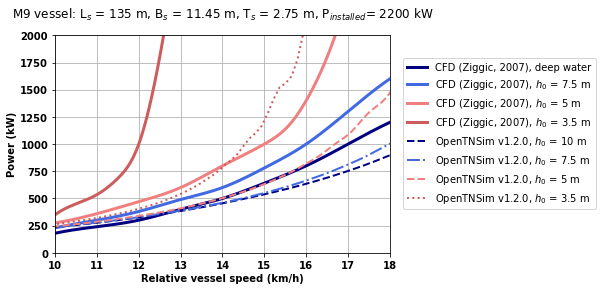

In [9]:
from scipy.interpolate import make_interp_spline, BSpline

plt.figure(figsize = (6,4))
V_DST_1=np.array([10,11,12,13,14,15,16,17,18]) # deep water
P_DST_1=np.array([180,240,300,400,500,640,800,1000,1200])
V_DST_2=np.array([10,11,12,13,14,15,16,17,18]) # h=7.5 m
P_DST_2=np.array([230,300,380,490,600,780,1000,1300,1600])
V_DST_3=np.array([10,11,12,13,14,15,15.65,16,16.5,16.7]) # h=5 m
P_DST_3=np.array([275,360,470,600,800,1000,1200,1400,1800,2005])
V_DST_4=np.array([10,10.5,11,11.5,12,12.5,13]) # h=3.5 m
P_DST_4=np.array([350,450,535,685,1000,1800,3000])
#define spline, make the lines smooth
V_DST_1_new = np.linspace(V_DST_1.min(), V_DST_1.max(), 200) 
V_DST_2_new = np.linspace(V_DST_2.min(), V_DST_2.max(), 200) 
V_DST_3_new = np.linspace(V_DST_3.min(), V_DST_3.max(), 200) 
V_DST_4_new = np.linspace(V_DST_4.min(), V_DST_4.max(), 200) 

spl1= make_interp_spline(V_DST_1,P_DST_1, k=3)
P_DST_1_new = spl1(V_DST_1_new)
spl2= make_interp_spline(V_DST_2,P_DST_2, k=3)
P_DST_2_new = spl2(V_DST_2_new)
spl3= make_interp_spline(V_DST_3,P_DST_3, k=3)
P_DST_3_new = spl3(V_DST_3_new)
spl4= make_interp_spline(V_DST_4,P_DST_4, k=3)
P_DST_4_new = spl4(V_DST_4_new)
                 
plt.plot(V_DST_1_new,P_DST_1_new,color='navy',linewidth = 3.0)
plt.plot(V_DST_2_new,P_DST_2_new,color='royalblue',linewidth = 3.0)
plt.plot(V_DST_3_new,P_DST_3_new,color='lightcoral',linewidth = 3.0)
plt.plot(V_DST_4_new,P_DST_4_new,color='indianred',linewidth = 3.0)

# selected = plot_df.query('c_year == 1990 and h_0 == 150 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='red',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 50 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='orange',linewidth = 2.0)
# selected = plot_df.query('c_year == 1990 and h_0 == 20 and P_tot < P_installed')
# plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='yellow',linewidth = 2.0)

selected = plot_df.query('C_year == 1990 and h_0 == 10 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='navy',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 7.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'-.', color='royalblue',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],'--', color='lightcoral',linewidth = 2.0)
selected = plot_df.query('C_year == 1990 and h_0 == 3.5 and P_tot < P_installed')
plt.plot(selected['V_s_km'], selected['P_tot'],':', color='indianred',linewidth = 2.0)
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['CFD (Ziggic, 2007), deep water', 'CFD (Ziggic, 2007), $h_0$ = 7.5 m', 'CFD (Ziggic, 2007), $h_0$ = 5 m', 'CFD (Ziggic, 2007), $h_0$ = 3.5 m',
        'OpenTNSim v1.2.0, $h_0$ = 10 m', 'OpenTNSim v1.2.0, $h_0$ = 7.5 m', 'OpenTNSim v1.2.0, $h_0$ = 5 m', 'OpenTNSim v1.2.0, $h_0$ = 3.5 m'],loc=(1.04,0.2))

plt.xlabel('Relative vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('total power required versus speed with diff water depths (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.title('M9 vessel: L$_s$ = 135 m, B$_s$ = 11.45 m, T$_s$ = 2.75 m, P$_{installed}$= 2200 kW',y=1.05)
plt.savefig('Fig_07_disable_squat.pdf',bbox_inches = 'tight',dpi=600, format='pdf') 
